# This notebook is to do cross-closure test using tau12 and tau31, to study the difference between two simulations (pythia and herwigg++)

In [ ]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi,tdrstyle
tdrstyle.setTDRStyle()
rt.gROOT.SetBatch()
rt.gROOT.ForceStyle()
rt.gStyle.SetOptStat(0)

In [3]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1.172e5,7.76e3,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626,3.205e8])
EventNumber=np.array([6730737.00,4150588.00,3815049.25,3371704.00,2008088.12,1156036.00,174078.00,154791.00,154929.00,125457.00,248842.97])
#CrossSection=3.205e8
#EventNumber=248842.97
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=['QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf','QCD Herwigg++']
print len(Scale),len(MC_Compo)
#MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[6.25149133e+02 6.71229040e+01 6.04256267e+00 1.97946848e+00
 5.73012254e-01 2.90840623e-01 1.73201091e-01 2.60698930e-02
 1.56465416e-03 4.65312035e-05 4.62403700e+07]
11 11


In [4]:
fData=[]
path='/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_JetHT2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt170to300.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt300to470.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt470to600.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt600to800.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt800to1000.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1000to1400.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1400to1800.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt1800to2400.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt2400to3200.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Pt3200toInf.root',
    '/work/algomez/work/Files/jetObservables/v04/jetObservables_histograms_QCD_Herwigpp.root'
]
print len(fMC)

7
11


# Functions to refill histograms to new bins

In [5]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Do unfolding

In [6]:
def DoUnfolding(Response,Reco):
    tunfolder = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolder.SetInput(Reco)
    tunfolder.DoUnfold(0.)
    return tunfolder.GetOutput("MC_unfolded")
def CrossClosure(response1,reco1,response2,reco2):
    unf11=DoUnfolding(response1,reco1)
    unf12=DoUnfolding(response1,reco2)
    unf21=DoUnfolding(response2,reco1)
    unf22=DoUnfolding(response2,reco2)
    return unf11,unf12,unf21,unf22

# $\tau_1^{(2)}$

In [7]:
reco='recoJet1_tau_2_1_nom_dijetSel'
fake='fakerecoJet1_tau_2_1_dijetSel'
gen='genJet1_tau_2_1_dijetSel'
response='respJet1_tau_2_1_nom_dijetSel'

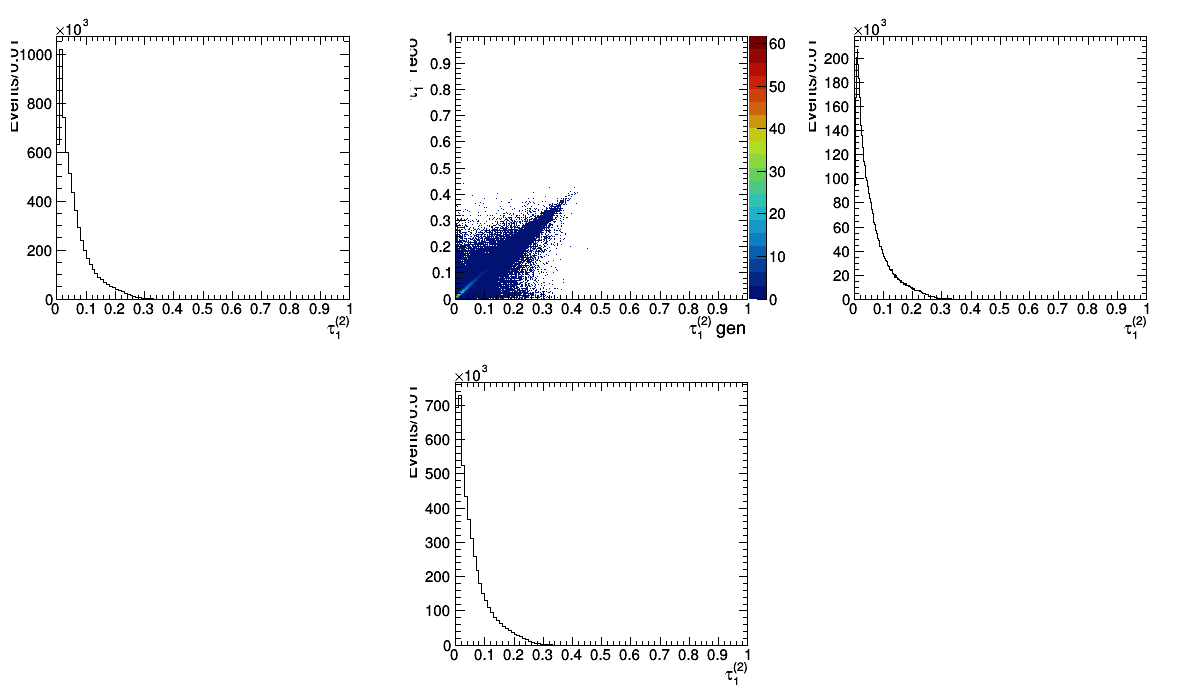

In [8]:
#1 for pythia, 2 for herwigg++
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{1}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{1}^{(2)};Events/0.01",400,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{1}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",400,0,1,400,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{1}^{(2)};Events/0.01",400,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{1}^{(2)};Events/0.01",100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",400,0,1,400,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    Data_reco0.Add(t.Get(fake))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
for i in range(len(fMC)-1):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC1_reco0.Add(t.Get(reco),Scale[i])
    MC1_gen0.Add(t.Get(gen),Scale[i])
    Response1_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()
    
f_MC[len(fMC)-1]=rt.TFile.Open(fMC[len(fMC)-1],'read')
t=f_MC[len(fMC)-1].Get('jetObservables')
MC2_reco0.Add(t.Get(reco),Scale[len(fMC)-1])
MC2_gen0.Add(t.Get(gen),Scale[len(fMC)-1])
Response2_0.Add(t.Get(response),Scale[len(fMC)-1])
f_MC[len(fMC)-1].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,720)
c0.Divide(3,2)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(3)
MC1_reco0.Draw("hist")
c0.cd(4)
#MC1_fake0.Draw("hist")
c0.cd(2)
Response1_0.Draw("Colz")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.Draw()

In [9]:
#Binnings are decided in 7.PurityStability_forCrossClosure_dijet.ipynb
gen_bin=np.array([0.0,0.03,0.06,0.09,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.46])
reco_bin=np.array([0.0,0.015,0.03,0.045,0.06,0.075,0.09,0.105,0.12,0.135,0.15,0.165,0.18,0.195,0.21,0.225,0.24,0.255,0.27,0.285,0.3,0.36,0.46])

In [10]:
MC1_reco=rt.TH1D("MC_reco Pythia","MC_reco Pythia;#tau_{1}^{(2)};Events/0.01",reco_bin.shape[0]-1,reco_bin)
MC1_gen=rt.TH1D("MC_gen Pythia","MC_gen Pythia;#tau_{1}^{(2)};Events/0.01",gen_bin.shape[0]-1,gen_bin)
Response1=rt.TH2D("Response matrix Pythia","Response matrix Pythia;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
MC2_reco=rt.TH1D("MC_reco Herwigg++","MC_reco Herwigg++;#tau_{1}^{(2)};Events/0.01",reco_bin.shape[0]-1,reco_bin)
MC2_gen=rt.TH1D("MC_gen Herwigg++","MC_gen Herwigg++;#tau_{1}^{(2)};Events/0.01",gen_bin.shape[0]-1,gen_bin)
Response2=rt.TH2D("Response matrix Herwigg++","Response matrix Herwigg++;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)

Fill1D(MC1_reco0,MC1_reco,reco_bin)
Fill1D(MC1_gen0,MC1_gen,gen_bin)
Fill2D(Response1_0,Response1,gen_bin,reco_bin)
Fill1D(MC2_reco0,MC2_reco,reco_bin)
Fill1D(MC2_gen0,MC2_gen,gen_bin)
Fill2D(Response2_0,Response2,gen_bin,reco_bin)

#unf11 is unfold reco1 with resp1;
#unf12 is unfold reco2 with resp1;
#unf21 is unfold reco1 with resp2;
#unf22 is unfold reco2 with resp2.
unf11,unf12,unf21,unf22=CrossClosure(Response1,MC1_reco,Response2,MC2_reco)

Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 22 input bins and 11 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #12 (xaxis:#tau_{1}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 22 input bins and 11 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #12 (xaxis:#tau_{1}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <TR

In [11]:
def Scale(h):
    n=h.Integral()
    h.Scale(1./n,"width")

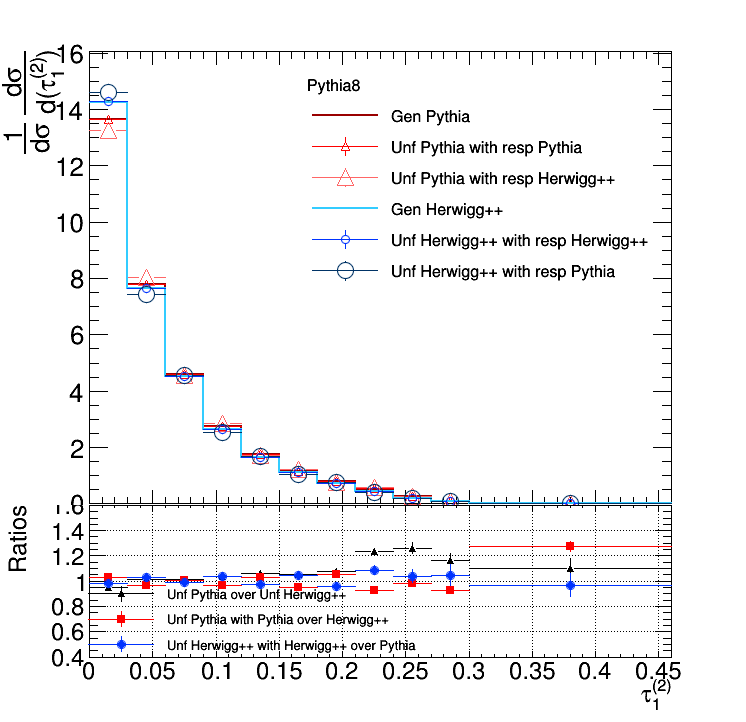

In [12]:
can = rt.TCanvas('can', 'can',  10, 10, 750, 750 )
pad1 = rt.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
pad2 = rt.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1)
pad1.Draw()
pad2.Draw()

pad1.cd()

legend1=rt.TLegend(0.4,0.5,0.90,0.88,"Pythia8")
legend1.SetFillStyle(0)
legend1.SetBorderSize(0)

Scale(MC1_gen)
Scale(unf11)
Scale(unf21)
Scale(MC2_gen)
Scale(unf22)
Scale(unf12)

MC1_gen.GetXaxis().SetTitle("#tau_{1}^{(2)}")
MC1_gen.GetYaxis().SetTitleSize(0.05)
MC1_gen.GetYaxis().SetTitleOffset(0.95)
MC1_gen.GetYaxis().SetLabelSize(0.05)
MC1_gen.GetYaxis().SetTitle("#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{1}^{(2)})}")
MC1_gen.SetMaximum(1.1*max([MC1_gen.GetMaximum(),MC2_gen.GetMaximum(),unf11.GetMaximum(),unf21.GetMaximum(),unf22.GetMaximum(),unf12.GetMaximum()]))
MC1_gen.SetLineColor(rt.kRed+2)
MC1_gen.SetLineWidth(2)
legend1.AddEntry(MC1_gen,"Gen Pythia","l")
MC1_gen.Draw("hist")

unf11.SetLineColor(rt.kRed)
unf11.SetMarkerColor(rt.kRed)
unf11.SetMarkerStyle(26)
unf11.SetMarkerSize(1)
legend1.AddEntry(unf11,"Unf Pythia with resp Pythia","lep")
unf11.Draw("e0same")

unf21.SetLineColor(rt.kRed-7)
unf21.SetMarkerColor(rt.kRed-7)
unf21.SetMarkerStyle(26)
unf21.SetMarkerSize(2)
legend1.AddEntry(unf21,"Unf Pythia with resp Herwigg++","lep")
unf21.Draw("e0same")

MC2_gen.SetLineColor(rt.kAzure+8)
MC2_gen.SetLineWidth(2)
legend1.AddEntry(MC2_gen,"Gen Herwigg++","l")
MC2_gen.Draw("histsame")

unf22.SetLineColor(rt.kAzure)
unf22.SetMarkerColor(rt.kAzure)
unf22.SetMarkerStyle(24)
unf22.SetMarkerSize(1)
legend1.AddEntry(unf22,"Unf Herwigg++ with resp Herwigg++","lep")
unf22.Draw("e0same")

unf12.SetLineColor(rt.kAzure+3)
unf12.SetMarkerColor(rt.kAzure+3)
unf12.SetMarkerStyle(24)
unf12.SetMarkerSize(2)
legend1.AddEntry(unf12,"Unf Herwigg++ with resp Pythia","lep")
unf12.Draw("e0same")

legend1.Draw("same")


pad2.cd()
rt.gStyle.SetOptFit(1)
pad2.SetGridx()
pad2.SetGridy()
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.3)

legend2=rt.TLegend(0.1,0.3,0.6,0.65)
legend2.SetBorderSize(0)
legend2.SetFillStyle(0)

ratio1=unf11.Clone("ratio1")
ratio1.Divide(unf22)
ratio1.GetXaxis().SetTitle("#tau_{1}^{(2)}")
ratio1.GetXaxis().SetTitleSize(0.12)
ratio1.GetXaxis().SetLabelSize(0.12)
ratio1.GetYaxis().SetTitle("Ratios")
ratio1.GetYaxis().SetTitleSize(0.12)
ratio1.GetYaxis().SetTitleOffset(0.5)
ratio1.GetYaxis().SetLabelSize(0.12)
ratio1.GetYaxis().SetRangeUser(0.4,1.6)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(rt.kBlack)
ratio1.SetLineColor(rt.kBlack)
ratio1.Draw("P0")
legend2.AddEntry(ratio1,"Unf Pythia over Unf Herwigg++","lep")

ratio2=unf11.Clone("ratio2")
ratio2.Divide(unf21)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(rt.kRed)
ratio2.Draw("P0same")
legend2.AddEntry(ratio2,"Unf Pythia with Pythia over Herwigg++","lep")

ratio3=unf22.Clone("ratio2")
ratio3.Divide(unf12)
ratio3.SetMarkerStyle(8)
ratio3.SetMarkerColor(rt.kAzure)
ratio3.Draw("P0same")
legend2.AddEntry(ratio3,"Unf Herwigg++ with Herwigg++ over Pythia","lep")

legend2.Draw("Same")

can.Draw()

# $\tau_{3}^{(1)}$

In [6]:
reco='recoJet1_tau_1_3_nom_dijetSel'
fake='fakerecoJet1_tau_1_3_dijetSel'
gen='genJet1_tau_1_3_dijetSel'
response='respJet1_tau_1_3_nom_dijetSel'

Warning in <TROOT::Append>: Replacing existing TH1: Data_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC1_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_reco0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC2_gen0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response2 (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c0


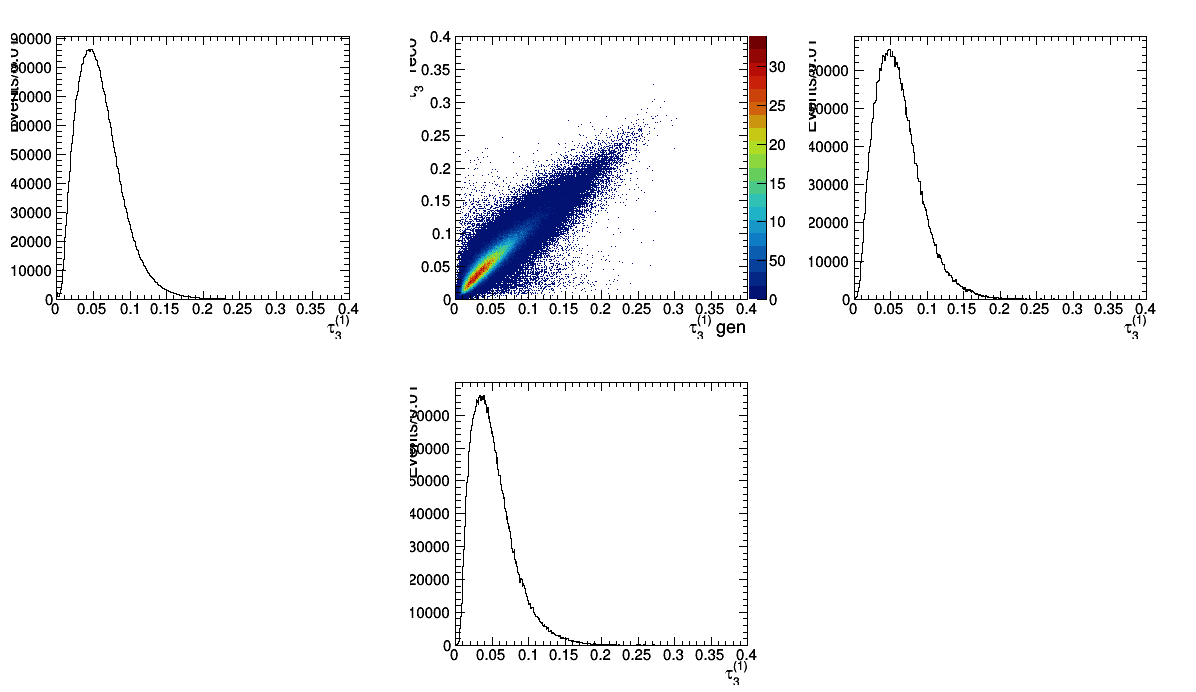

In [9]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
Response1_0=rt.TH2D("Response1","Response1;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",400,0,0.4,400,0,0.4)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{3}^{(1)};Events/0.01",400,0,0.4)
Response2_0=rt.TH2D("Response2","Response2;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",400,0,0.4,400,0,0.4)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    Data_reco0.Add(t.Get(fake))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
for i in range(len(fMC)-1):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    MC1_reco0.Add(t.Get(reco),Scale[i])
    MC1_gen0.Add(t.Get(gen),Scale[i])
    Response1_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()
    
f_MC[len(fMC)-1]=rt.TFile.Open(fMC[len(fMC)-1],'read')
t=f_MC[len(fMC)-1].Get('jetObservables')
MC2_reco0.Add(t.Get(reco),Scale[len(fMC)-1])
MC2_gen0.Add(t.Get(gen),Scale[len(fMC)-1])
Response2_0.Add(t.Get(response),Scale[len(fMC)-1])
f_MC[len(fMC)-1].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,720)
c0.Divide(3,2)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(3)
MC1_reco0.Draw("hist")
c0.cd(4)
#MC1_fake0.Draw("hist")
c0.cd(2)
Response1_0.Draw("Colz")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.Draw()

In [15]:
gen_bin=np.array([0.0,0.032,0.064,0.096,0.128,0.16,0.192,0.224,0.3])
reco_bin=np.array([0.0,0.016,0.032,0.048,0.064,0.08,0.096,0.112,0.128,0.144,0.16,0.176,0.192,0.208,0.224,0.25,0.3])

In [16]:
MC1_reco=rt.TH1D("MC_reco Pythia","MC_reco Pythia;#tau_{3}^{(1)};Events/0.01",reco_bin.shape[0]-1,reco_bin)
MC1_gen=rt.TH1D("MC_gen Pythia","MC_gen Pythia;#tau_{3}^{(1)};Events/0.01",gen_bin.shape[0]-1,gen_bin)
Response1=rt.TH2D("Response matrix Pythia","Response matrix Pythia;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
MC2_reco=rt.TH1D("MC_reco Herwigg++","MC_reco Herwigg++;#tau_{3}^{(1)};Events/0.01",reco_bin.shape[0]-1,reco_bin)
MC2_gen=rt.TH1D("MC_gen Herwigg++","MC_gen Herwigg++;#tau_{3}^{(1)};Events/0.01",gen_bin.shape[0]-1,gen_bin)
Response2=rt.TH2D("Response matrix Herwigg++","Response matrix Herwigg++;#tau_{3}^{(1)} gen;#tau_{3}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)

Fill1D(MC1_reco0,MC1_reco,reco_bin)
Fill1D(MC1_gen0,MC1_gen,gen_bin)
Fill2D(Response1_0,Response1,gen_bin,reco_bin)
Fill1D(MC2_reco0,MC2_reco,reco_bin)
Fill1D(MC2_gen0,MC2_gen,gen_bin)
Fill2D(Response2_0,Response2,gen_bin,reco_bin)

unf11,unf12,unf21,unf22=CrossClosure(Response1,MC1_reco,Response2,MC2_reco)

Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Pythia (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Pythia (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response matrix Pythia (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen Herwigg++ (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response matrix Herwigg++ (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 16 input bins and 8 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{3}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #9 (xaxis:#tau_{3}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


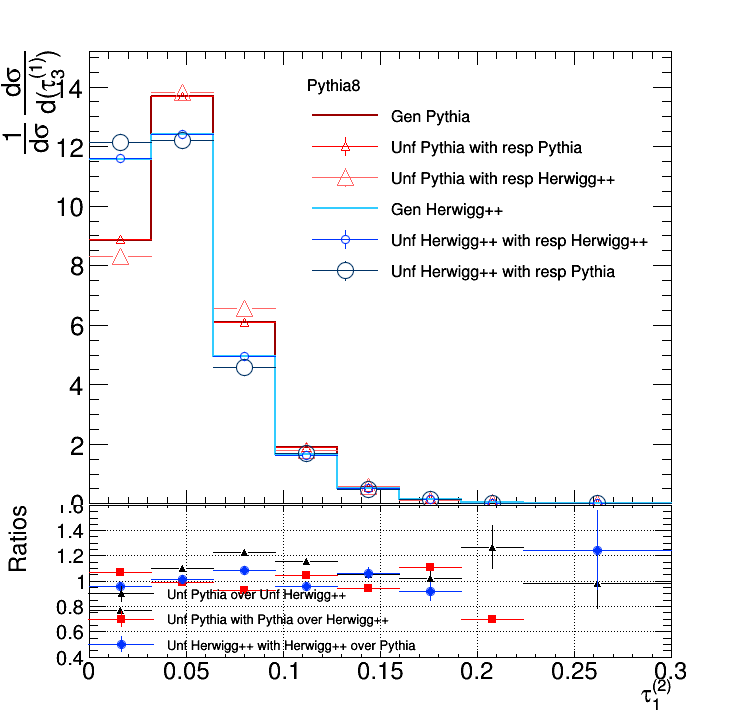

In [23]:
can = rt.TCanvas('can', 'can',  10, 10, 750, 750 )
pad1 = rt.TPad("pad1", "Main",0,0.207,1.00,1.00,-1)
pad2 = rt.TPad("pad2", "Ratio",0,0.00,1.00,0.30,-1)
pad1.Draw()
pad2.Draw()

pad1.cd()

legend1=rt.TLegend(0.4,0.5,0.90,0.88,"Pythia8")
legend1.SetFillStyle(0)
legend1.SetBorderSize(0)

Scale(MC1_gen)
Scale(unf11)
Scale(unf21)
Scale(MC2_gen)
Scale(unf22)
Scale(unf12)

MC1_gen.GetXaxis().SetTitle("#tau_{1}^{(2)}")
MC1_gen.GetYaxis().SetTitleSize(0.05)
MC1_gen.GetYaxis().SetTitleOffset(0.95)
MC1_gen.GetYaxis().SetLabelSize(0.05)
MC1_gen.GetYaxis().SetTitle("#frac{1}{d#sigma} #frac{d#sigma}{d(#tau_{3}^{(1)})}")
MC1_gen.SetMaximum(1.1*max([MC1_gen.GetMaximum(),MC2_gen.GetMaximum(),unf11.GetMaximum(),unf21.GetMaximum(),unf22.GetMaximum(),unf12.GetMaximum()]))
MC1_gen.SetLineColor(rt.kRed+2)
MC1_gen.SetLineWidth(2)
legend1.AddEntry(MC1_gen,"Gen Pythia","l")
MC1_gen.Draw("hist")

unf11.SetLineColor(rt.kRed)
unf11.SetMarkerColor(rt.kRed)
unf11.SetMarkerStyle(26)
unf11.SetMarkerSize(1)
legend1.AddEntry(unf11,"Unf Pythia with resp Pythia","lep")
unf11.Draw("e0same")

unf21.SetLineColor(rt.kRed-7)
unf21.SetMarkerColor(rt.kRed-7)
unf21.SetMarkerStyle(26)
unf21.SetMarkerSize(2)
legend1.AddEntry(unf21,"Unf Pythia with resp Herwigg++","lep")
unf21.Draw("e0same")

MC2_gen.SetLineColor(rt.kAzure+8)
MC2_gen.SetLineWidth(2)
legend1.AddEntry(MC2_gen,"Gen Herwigg++","l")
MC2_gen.Draw("histsame")

unf22.SetLineColor(rt.kAzure)
unf22.SetMarkerColor(rt.kAzure)
unf22.SetMarkerStyle(24)
unf22.SetMarkerSize(1)
legend1.AddEntry(unf22,"Unf Herwigg++ with resp Herwigg++","lep")
unf22.Draw("e0same")

unf12.SetLineColor(rt.kAzure+3)
unf12.SetMarkerColor(rt.kAzure+3)
unf12.SetMarkerStyle(24)
unf12.SetMarkerSize(2)
legend1.AddEntry(unf12,"Unf Herwigg++ with resp Pythia","lep")
unf12.Draw("e0same")

legend1.Draw("same")


pad2.cd()
rt.gStyle.SetOptFit(1)
pad2.SetGridx()
pad2.SetGridy()
pad2.SetTopMargin(0)
pad2.SetBottomMargin(0.3)

legend2=rt.TLegend(0.1,0.3,0.6,0.65)
legend2.SetBorderSize(0)
legend2.SetFillStyle(0)

ratio1=unf11.Clone("ratio1")
ratio1.Divide(unf22)
ratio1.GetXaxis().SetTitle("#tau_{1}^{(2)}")
ratio1.GetXaxis().SetTitleSize(0.12)
ratio1.GetXaxis().SetLabelSize(0.12)
ratio1.GetYaxis().SetTitle("Ratios")
ratio1.GetYaxis().SetTitleSize(0.12)
ratio1.GetYaxis().SetTitleOffset(0.5)
ratio1.GetYaxis().SetLabelSize(0.1)
ratio1.GetYaxis().SetRangeUser(0.4,1.6)
ratio1.SetMarkerStyle(22)
ratio1.SetMarkerColor(rt.kBlack)
ratio1.SetLineColor(rt.kBlack)
ratio1.Draw("P0")
legend2.AddEntry(ratio1,"Unf Pythia over Unf Herwigg++","lep")

ratio2=unf11.Clone("ratio2")
ratio2.Divide(unf21)
ratio2.SetMarkerStyle(21)
ratio2.SetMarkerColor(rt.kRed)
ratio2.Draw("P0same")
legend2.AddEntry(ratio2,"Unf Pythia with Pythia over Herwigg++","lep")

ratio3=unf22.Clone("ratio2")
ratio3.Divide(unf12)
ratio3.SetMarkerStyle(8)
ratio3.SetMarkerColor(rt.kAzure)
ratio3.Draw("P0same")
legend2.AddEntry(ratio3,"Unf Herwigg++ with Herwigg++ over Pythia","lep")

legend2.Draw("Same")

can.Draw()